In [1]:
from standards import *
import matplotlib.patches as patches

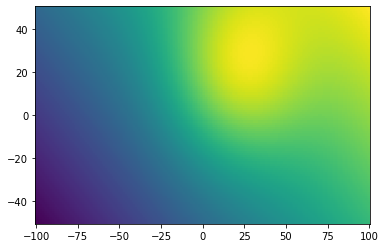

In [2]:
x = np.linspace(-100, 100, 201)
y = np.linspace(-50, 50, 101)
X, Y = np.meshgrid(x, y)

groundTruth = np.exp(-1 * ((X-20)**2 + (Y-20)**2)/40**2) + 0.01*(X+Y)
plt.pcolormesh(x, y, groundTruth, shading = 'auto')

In [5]:
def createKacheln(x, y, groundTruth, kachelCols = 3, kachelRows = 2):
    cutsCols = [0] + [int((i+1) * len(x)/kachelCols) for i in range(kachelCols-1)] + [len(x)]
    cutsRows = [0] + [int((i+1) * len(y)/kachelRows) for i in range(kachelRows-1)] + [len(y)]
    centersX = [np.mean(x[cutsCols[i]:cutsCols[i+1]]) for i in range(kachelCols)]
    centersY = [np.mean(y[cutsRows[i]:cutsRows[i+1]]) for i in range(kachelRows)]
    
    coords = []
    values = []
    fullKachelData = np.zeros(groundTruth.shape)
    for i in range(kachelCols):
        for j in range(kachelRows):
            coords.append([centersX[i], centersY[j]])
            values.append(np.mean(groundTruth[cutsRows[j]:cutsRows[j+1], cutsCols[i]:cutsCols[i+1]]))
            fullKachelData[cutsRows[j]:cutsRows[j+1], cutsCols[i]:cutsCols[i+1]] = values[-1]
    coords = np.asarray(coords)
    values = np.asarray(values)
    
    return coords, values, fullKachelData

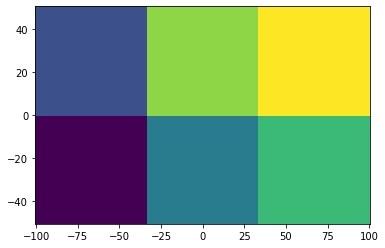

In [6]:
kachelCoords, kachelValues, fullKachelData = createKacheln(x, y, groundTruth, 3, 2)
plt.pcolormesh(x, y, fullKachelData, shading = 'auto')

In [7]:
numPoints = 6
pointsX = np.random.randint(0, len(x), size = 6)
pointsY = np.random.randint(0, len(y), size = 6)
pointCoords = [[x[pointsX[i]], y[pointsY[i]]] for i in range(numPoints)]
pointsValues = [groundTruth[pointsY[i], pointsX[i]] for i in range(numPoints)]

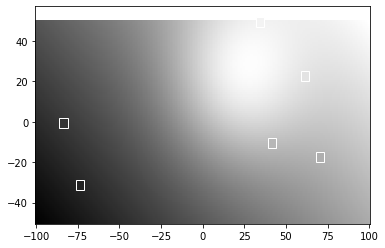

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
scaledGroundTruth = (groundTruth - np.min(groundTruth))/(np.max(groundTruth)- np.min(groundTruth))
plt.pcolormesh(x, y, scaledGroundTruth, shading = 'auto', cmap = 'gray')
for i in range(numPoints):
    val = groundTruth[pointsY[i], pointsX[i]]
    c = (val- np.min(groundTruth))/(np.max(groundTruth)- np.min(groundTruth))
    rect = plt.Rectangle(pointCoords[i], 5, 5, ec = [1, 1, 1], fc = [c, c, c])
    ax.add_patch(rect)

In [19]:
def calcDistance(X, Y, coords):
    distance = np.sqrt((X-coords[0])**2 + (Y - coords[1])**2)
    return distance

In [20]:
def twoDimBarnes(x, y, pointCoords, pointValues, kachelCoords, kachelValues, params = None):
    X, Y = np.meshgrid(x, y)
    pointCoords = np.asarray(pointCoords)
    pointValues = np.asarray(pointValues)
    kachelCoords = np.asarray(kachelCoords)
    kachelValues = np.asarray(kachelValues)
    
    kappa_point = None
    kappa_kachel = None
    relKachelWeight = None
    if params == None or len(params) != 3:
        kappa_point = 10**2
        kappa_kachel = 50**2
        relKachelWeight = 0.2
    else:
        kappa_point = params[0]
        kappa_kachel = params[1]
        relKachelWeight = params[2]
    
    
    #weights: shape: (number of points, gridpoints)
    #probably could be optimized
    weightsPoints = np.asarray([np.exp(-1 * (calcDistance(X, Y, pointpos))**2/kappa_point) for pointpos in pointCoords])
    weightsKacheln = np.asarray([relKachelWeight * np.exp(-1 * (calcDistance(X, Y, kachelpos))**2/kappa_kachel) for kachelpos in kachelCoords])
    
    #multiply weights correctly with the measured values
    weightedPointValues = np.zeros(weightsPoints.shape)
    for i in range(len(pointValues)):
        weightedPointValues[i, :] = pointValues[i] * weightsPoints[i, :]
    
    weightedKachelValues = np.zeros(weightsKacheln.shape)
    for i in range(len(kachelValues)):
        weightedKachelValues[i, :] = kachelValues[i] * weightsKacheln[i, :]
        
    summedWeightedPointValues = np.sum(weightedPointValues, axis = 0)
    summedWeightedKachelValues = np.sum(weightedKachelValues, axis = 0)
    
    #first pass Barnes Interpolation
    interpol = (summedWeightedPointValues + summedWeightedKachelValues)/ (np.sum(weightsPoints, axis = 0) + np.sum(weightsKacheln, axis = 0))
    
    return interpol

In [21]:
interpol = twoDimBarnes(x, y, pointCoords, pointsValues, kachelCoords, kachelValues)

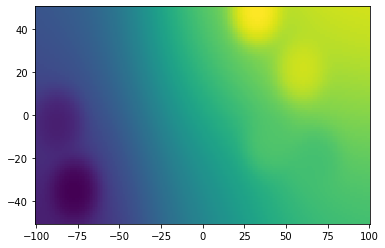

In [22]:
plt.pcolormesh(x, y, interpol, shading = 'auto')

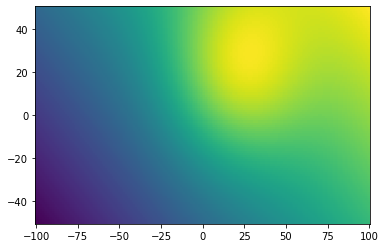

In [24]:
plt.pcolormesh(x, y, groundTruth, shading = 'auto')

In [23]:
residualBarnes = groundTruth - interpol
residualKacheln = groundTruth - fullKachelData
print(np.std(residualBarnes))
print(np.std(residualKacheln))
print(np.mean(np.abs(residualBarnes)))
print(np.mean(np.abs(residualKacheln)))

0.2710488069738837
0.31485014659181
0.21610044496925662
0.24917316512624244
